# Preprocessing data

In [ ]:
# importing dependencies
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving charity_data.csv to charity_data (1).csv


In [ ]:
# reading in data
import io
application_df = pd.read_csv(io.BytesIO(uploaded['charity_data.csv']))
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [ ]:
# dropping "EIN", "NAME", "APPLICATION_TYPE" since non beneficial
application_df = application_df.drop(columns=['EIN', 'NAME'])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [ ]:
# checking for number of unique values per variable
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [ ]:
# determining value counts for binning APPLICATION_TYPE column
app_count = application_df.APPLICATION_TYPE.value_counts()
app_count

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

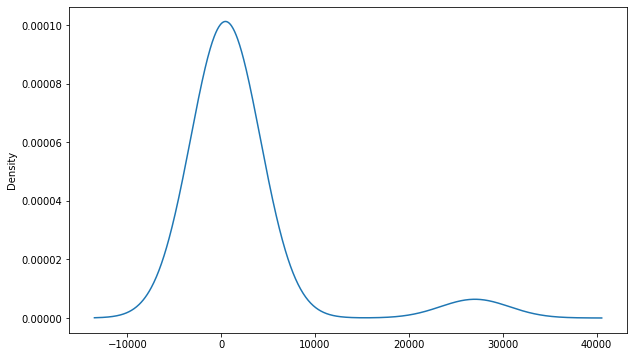

In [ ]:
# plotting density of app_count
app_count.plot.density(figsize=(10,6))

In [ ]:
# determining values to replace if counts are less than 500
replace_application = list(app_count[app_count < 500].index)

# replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,'other')

# checking if binning established
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
other      276
Name: APPLICATION_TYPE, dtype: int64

In [ ]:
# determining value counts for binning CLASSIFICATION column
class_count = application_df.CLASSIFICATION.value_counts()
class_count

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C1900        1
C1283        1
C1820        1
C1370        1
C4120        1
Name: CLASSIFICATION, Length: 71, dtype: int64

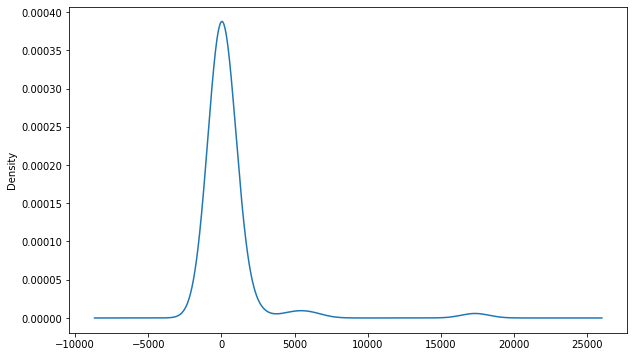

In [ ]:
# plotting density of class_count
class_count.plot.density(figsize=(10,6))

In [ ]:
# determining values to replace if counts less than 1000
replace_class = list(class_count[class_count < 1000].index)

# replacing in dataframe and categorizing under 'other'
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,'other')

# checking if binning established
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [ ]:
# creating categorical variable list
application_cat = application_df.dtypes[application_df.dtypes =='object'].index.tolist()

In [ ]:
# initiating OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# fit and transform OneHotEncoder using categorical list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# add encoded variable to dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,APPLICATION_TYPE_other,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# merging encoded features to original dataframe and dropping columns
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,APPLICATION_TYPE_other,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# naming target and feature variables from preprocessed data
y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns=['IS_SUCCESSFUL'])

# splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# initiate standardscaler instance
scaler = StandardScaler()

# fit standardscaler
X_scaler = scaler.fit(X_train)

# scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# creating method to create sequential model with hyperparameter options
def create_model(hp):
  nn_model = tf.keras.models.Sequential()

  activation = hp.Choice('activation',['relu','tanh','sigmoid'])

  nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
                min_value=1, max_value=80, step=2), 
                activation=activation, input_dim=len(X_train_scaled[0])))
  
  for i in range(hp.Int('num_layers',1, 6)):
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                 min_value=1, max_value=40, step=2),
                 activation=activation))
    
  nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return nn_model


In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=1a56df5a7d07c2dfefffac85ab8bed959ad603dca60c0c1a60175ad59d8a257c
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=0449dbd3f7d40548f465ae1fcf4ff613a627eeba2505ea0eced446dcdebee306
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import kerastuner as kt

tuner = kt.Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=100,
    hyperband_iterations=2)

In [ ]:
tuner.search(X_train_scaled, y_train, epochs=100,validation_data=(X_test_scaled, y_test))

Trial 508 Complete [00h 02m 59s]
val_accuracy: 0.7334110736846924

Best val_accuracy So Far: 0.7350437045097351
Total elapsed time: 02h 27m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'sigmoid',
 'first_units': 61,
 'num_layers': 6,
 'tuner/bracket': 1,
 'tuner/epochs': 34,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_0': 19,
 'units_1': 31,
 'units_2': 35,
 'units_3': 15,
 'units_4': 23,
 'units_5': 39}

In [ ]:
best_model = tuner.get_best_models(1)[0]
loss, accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Loss: {loss}, Accuracy: {accuracy}')

268/268 - 0s - loss: 0.5681 - accuracy: 0.7350
Loss: 0.5680710077285767, Accuracy: 0.7350437045097351


# Compiling, training and evaluating model to acheive over 75% accuracy

## Attempt 1 

In [ ]:
# defining model - increasing nodes for 1st layer, lowering nodes for 2nd layer and creating 3rd layer
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# first layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,
                            input_dim=number_input_features,
                            activation='relu'))

# second layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# third layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='relu'))

# output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# structure of model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                3520      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 6,271
Trainable params: 6,271
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling the model and customizing 
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# creating checkpoints for training
# defining checkpoint path and filename
os.makedirs("checkpoints/", exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

# creating callback to save model's weight ever 5 epochs
cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                             save_weights_only=True, save_freq=100)

In [ ]:
# train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100,callbacks=[cp_callback])

Epoch 1/100
 97/804 [==>...........................] - ETA: 1s - loss: 0.6574 - accuracy: 0.6506
Epoch 00001: saving model to checkpoints\weights.01.hdf5
182/804 [=====>........................] - ETA: 2s - loss: 0.6383 - accuracy: 0.6691
Epoch 00001: saving model to checkpoints\weights.01.hdf5
288/804 [=========>....................] - ETA: 1s - loss: 0.6236 - accuracy: 0.6825
Epoch 00001: saving model to checkpoints\weights.01.hdf5
392/804 [=============>................] - ETA: 1s - loss: 0.6148 - accuracy: 0.6896
Epoch 00001: saving model to checkpoints\weights.01.hdf5
495/804 [=================>............] - ETA: 1s - loss: 0.6083 - accuracy: 0.6942
Epoch 00001: saving model to checkpoints\weights.01.hdf5
583/804 [====================>.........] - ETA: 0s - loss: 0.6041 - accuracy: 0.6973
Epoch 00001: saving model to checkpoints\weights.01.hdf5
677/804 [========================>.....] - ETA: 0s - loss: 0.6004 - accuracy: 0.6999
Epoch 00001: saving model to checkpoints\weights.01

572/804 [====================>.........] - ETA: 0s - loss: 0.5415 - accuracy: 0.7389
Epoch 00007: saving model to checkpoints\weights.07.hdf5
665/804 [=======================>......] - ETA: 0s - loss: 0.5425 - accuracy: 0.7380
Epoch 00007: saving model to checkpoints\weights.07.hdf5
764/804 [===========================>..] - ETA: 0s - loss: 0.5431 - accuracy: 0.7374
Epoch 00007: saving model to checkpoints\weights.07.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5433 - accuracy: 0.7372
Epoch 8/100
 50/804 [>.............................] - ETA: 2s - loss: 0.5463 - accuracy: 0.7353
Epoch 00008: saving model to checkpoints\weights.08.hdf5
163/804 [=====>........................] - ETA: 2s - loss: 0.5484 - accuracy: 0.7294
Epoch 00008: saving model to checkpoints\weights.08.hdf5
258/804 [========>.....................] - ETA: 1s - loss: 0.5487 - accuracy: 0.7290
Epoch 00008: saving model to checkpoints\weights.08.hdf5
364/804 [============>.................] - ETA:

239/804 [=======>......................] - ETA: 1s - loss: 0.5428 - accuracy: 0.7378
Epoch 00014: saving model to checkpoints\weights.14.hdf5
329/804 [===========>..................] - ETA: 1s - loss: 0.5415 - accuracy: 0.7381
Epoch 00014: saving model to checkpoints\weights.14.hdf5
447/804 [===============>..............] - ETA: 1s - loss: 0.5414 - accuracy: 0.7374
Epoch 00014: saving model to checkpoints\weights.14.hdf5
546/804 [===================>..........] - ETA: 0s - loss: 0.5416 - accuracy: 0.7371
Epoch 00014: saving model to checkpoints\weights.14.hdf5
637/804 [======================>.......] - ETA: 0s - loss: 0.5417 - accuracy: 0.7369
Epoch 00014: saving model to checkpoints\weights.14.hdf5
743/804 [==========================>...] - ETA: 0s - loss: 0.5421 - accuracy: 0.7365
Epoch 00014: saving model to checkpoints\weights.14.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5422 - accuracy: 0.7364
Epoch 15/100
 40/804 [>.............................] - ETA

718/804 [=========================>....] - ETA: 0s - loss: 0.5429 - accuracy: 0.7343
Epoch 00020: saving model to checkpoints\weights.20.hdf5
804/804 [==============================] - 6s 8ms/step - loss: 0.5428 - accuracy: 0.7344
Epoch 21/100
 12/804 [..............................] - ETA: 3s - loss: 0.5536 - accuracy: 0.7231
Epoch 00021: saving model to checkpoints\weights.21.hdf5
116/804 [===>..........................] - ETA: 4s - loss: 0.5377 - accuracy: 0.7400
Epoch 00021: saving model to checkpoints\weights.21.hdf5
220/804 [=======>......................] - ETA: 4s - loss: 0.5345 - accuracy: 0.7405
Epoch 00021: saving model to checkpoints\weights.21.hdf5
313/804 [==========>...................] - ETA: 3s - loss: 0.5350 - accuracy: 0.7399
Epoch 00021: saving model to checkpoints\weights.21.hdf5
416/804 [==============>...............] - ETA: 2s - loss: 0.5359 - accuracy: 0.7394
Epoch 00021: saving model to checkpoints\weights.21.hdf5
518/804 [==================>...........] - ETA

293/804 [=========>....................] - ETA: 2s - loss: 0.5377 - accuracy: 0.7376
Epoch 00027: saving model to checkpoints\weights.27.hdf5
396/804 [=============>................] - ETA: 1s - loss: 0.5366 - accuracy: 0.7392
Epoch 00027: saving model to checkpoints\weights.27.hdf5
492/804 [=================>............] - ETA: 1s - loss: 0.5362 - accuracy: 0.7396
Epoch 00027: saving model to checkpoints\weights.27.hdf5
587/804 [====================>.........] - ETA: 0s - loss: 0.5362 - accuracy: 0.7398
Epoch 00027: saving model to checkpoints\weights.27.hdf5
689/804 [========================>.....] - ETA: 0s - loss: 0.5365 - accuracy: 0.7396
Epoch 00027: saving model to checkpoints\weights.27.hdf5
790/804 [============================>.] - ETA: 0s - loss: 0.5368 - accuracy: 0.7393
Epoch 00027: saving model to checkpoints\weights.27.hdf5
804/804 [==============================] - 4s 4ms/step - loss: 0.5369 - accuracy: 0.7392
Epoch 28/100
 78/804 [=>............................] - ETA

768/804 [===========================>..] - ETA: 0s - loss: 0.5365 - accuracy: 0.7397
Epoch 00033: saving model to checkpoints\weights.33.hdf5
804/804 [==============================] - 4s 4ms/step - loss: 0.5367 - accuracy: 0.7396
Epoch 34/100
 54/804 [=>............................] - ETA: 2s - loss: 0.5323 - accuracy: 0.7217
Epoch 00034: saving model to checkpoints\weights.34.hdf5
165/804 [=====>........................] - ETA: 2s - loss: 0.5279 - accuracy: 0.7367
Epoch 00034: saving model to checkpoints\weights.34.hdf5
268/804 [=========>....................] - ETA: 1s - loss: 0.5284 - accuracy: 0.7399
Epoch 00034: saving model to checkpoints\weights.34.hdf5
353/804 [============>.................] - ETA: 1s - loss: 0.5295 - accuracy: 0.7401
Epoch 00034: saving model to checkpoints\weights.34.hdf5
449/804 [===============>..............] - ETA: 1s - loss: 0.5307 - accuracy: 0.7395
Epoch 00034: saving model to checkpoints\weights.34.hdf5
551/804 [===================>..........] - ETA

333/804 [===========>..................] - ETA: 1s - loss: 0.5329 - accuracy: 0.7448
Epoch 00040: saving model to checkpoints\weights.40.hdf5
431/804 [===============>..............] - ETA: 1s - loss: 0.5343 - accuracy: 0.7431
Epoch 00040: saving model to checkpoints\weights.40.hdf5
531/804 [==================>...........] - ETA: 0s - loss: 0.5349 - accuracy: 0.7422
Epoch 00040: saving model to checkpoints\weights.40.hdf5
634/804 [======================>.......] - ETA: 0s - loss: 0.5354 - accuracy: 0.7416
Epoch 00040: saving model to checkpoints\weights.40.hdf5
729/804 [==========================>...] - ETA: 0s - loss: 0.5356 - accuracy: 0.7412
Epoch 00040: saving model to checkpoints\weights.40.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5357 - accuracy: 0.7410
Epoch 41/100
 25/804 [..............................] - ETA: 1s - loss: 0.5692 - accuracy: 0.6919
Epoch 00041: saving model to checkpoints\weights.41.hdf5
133/804 [===>..........................] - ETA

804/804 [==============================] - 3s 3ms/step - loss: 0.5380 - accuracy: 0.7350
Epoch 47/100
  1/804 [..............................] - ETA: 2s - loss: 0.3917 - accuracy: 0.9062
Epoch 00047: saving model to checkpoints\weights.47.hdf5
103/804 [==>...........................] - ETA: 2s - loss: 0.5334 - accuracy: 0.7527
Epoch 00047: saving model to checkpoints\weights.47.hdf5
211/804 [======>.......................] - ETA: 1s - loss: 0.5334 - accuracy: 0.7477
Epoch 00047: saving model to checkpoints\weights.47.hdf5
298/804 [==========>...................] - ETA: 1s - loss: 0.5338 - accuracy: 0.7459
Epoch 00047: saving model to checkpoints\weights.47.hdf5
404/804 [==============>...............] - ETA: 1s - loss: 0.5338 - accuracy: 0.7446
Epoch 00047: saving model to checkpoints\weights.47.hdf5
515/804 [==================>...........] - ETA: 0s - loss: 0.5335 - accuracy: 0.7438
Epoch 00047: saving model to checkpoints\weights.47.hdf5
596/804 [=====================>........] - ETA

384/804 [=============>................] - ETA: 1s - loss: 0.5393 - accuracy: 0.7358
Epoch 00053: saving model to checkpoints\weights.53.hdf5
489/804 [=================>............] - ETA: 0s - loss: 0.5393 - accuracy: 0.7359
Epoch 00053: saving model to checkpoints\weights.53.hdf5
584/804 [====================>.........] - ETA: 0s - loss: 0.5390 - accuracy: 0.7360
Epoch 00053: saving model to checkpoints\weights.53.hdf5
675/804 [========================>.....] - ETA: 0s - loss: 0.5385 - accuracy: 0.7363
Epoch 00053: saving model to checkpoints\weights.53.hdf5
781/804 [============================>.] - ETA: 0s - loss: 0.5382 - accuracy: 0.7366
Epoch 00053: saving model to checkpoints\weights.53.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5381 - accuracy: 0.7367
Epoch 54/100
 72/804 [=>............................] - ETA: 1s - loss: 0.5412 - accuracy: 0.7356
Epoch 00054: saving model to checkpoints\weights.54.hdf5
187/804 [=====>........................] - ETA

804/804 [==============================] - 4s 5ms/step - loss: 0.5354 - accuracy: 0.7401
Epoch 60/100
 61/804 [=>............................] - ETA: 3s - loss: 0.5328 - accuracy: 0.7335
Epoch 00060: saving model to checkpoints\weights.60.hdf5
155/804 [====>.........................] - ETA: 3s - loss: 0.5332 - accuracy: 0.7408
Epoch 00060: saving model to checkpoints\weights.60.hdf5
255/804 [========>.....................] - ETA: 2s - loss: 0.5345 - accuracy: 0.7417
Epoch 00060: saving model to checkpoints\weights.60.hdf5
358/804 [============>.................] - ETA: 1s - loss: 0.5342 - accuracy: 0.7418
Epoch 00060: saving model to checkpoints\weights.60.hdf5
439/804 [===============>..............] - ETA: 1s - loss: 0.5340 - accuracy: 0.7418
Epoch 00060: saving model to checkpoints\weights.60.hdf5
556/804 [===================>..........] - ETA: 0s - loss: 0.5340 - accuracy: 0.7416
Epoch 00060: saving model to checkpoints\weights.60.hdf5
658/804 [=======================>......] - ETA

439/804 [===============>..............] - ETA: 1s - loss: 0.5347 - accuracy: 0.7387
Epoch 00066: saving model to checkpoints\weights.66.hdf5
535/804 [==================>...........] - ETA: 1s - loss: 0.5342 - accuracy: 0.7392
Epoch 00066: saving model to checkpoints\weights.66.hdf5
626/804 [======================>.......] - ETA: 0s - loss: 0.5342 - accuracy: 0.7393
Epoch 00066: saving model to checkpoints\weights.66.hdf5
717/804 [=========================>....] - ETA: 0s - loss: 0.5343 - accuracy: 0.7393
Epoch 00066: saving model to checkpoints\weights.66.hdf5
804/804 [==============================] - 4s 4ms/step - loss: 0.5345 - accuracy: 0.7393
Epoch 67/100
 34/804 [>.............................] - ETA: 2s - loss: 0.5542 - accuracy: 0.7315
Epoch 00067: saving model to checkpoints\weights.67.hdf5
129/804 [===>..........................] - ETA: 2s - loss: 0.5515 - accuracy: 0.7306
Epoch 00067: saving model to checkpoints\weights.67.hdf5
225/804 [=======>......................] - ETA

  1/804 [..............................] - ETA: 2s - loss: 0.5478 - accuracy: 0.7500
Epoch 00073: saving model to checkpoints\weights.73.hdf5
 93/804 [==>...........................] - ETA: 2s - loss: 0.5435 - accuracy: 0.7373
Epoch 00073: saving model to checkpoints\weights.73.hdf5
202/804 [======>.......................] - ETA: 2s - loss: 0.5415 - accuracy: 0.7384
Epoch 00073: saving model to checkpoints\weights.73.hdf5
293/804 [=========>....................] - ETA: 1s - loss: 0.5404 - accuracy: 0.7387
Epoch 00073: saving model to checkpoints\weights.73.hdf5
390/804 [=============>................] - ETA: 1s - loss: 0.5395 - accuracy: 0.7388
Epoch 00073: saving model to checkpoints\weights.73.hdf5
507/804 [=================>............] - ETA: 0s - loss: 0.5387 - accuracy: 0.7389
Epoch 00073: saving model to checkpoints\weights.73.hdf5
592/804 [=====================>........] - ETA: 0s - loss: 0.5382 - accuracy: 0.7389
Epoch 00073: saving model to checkpoints\weights.73.hdf5
693/80

477/804 [================>.............] - ETA: 1s - loss: 0.5358 - accuracy: 0.7390
Epoch 00079: saving model to checkpoints\weights.79.hdf5
576/804 [====================>.........] - ETA: 0s - loss: 0.5359 - accuracy: 0.7391
Epoch 00079: saving model to checkpoints\weights.79.hdf5
685/804 [========================>.....] - ETA: 0s - loss: 0.5357 - accuracy: 0.7392
Epoch 00079: saving model to checkpoints\weights.79.hdf5
787/804 [============================>.] - ETA: 0s - loss: 0.5357 - accuracy: 0.7393
Epoch 00079: saving model to checkpoints\weights.79.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5356 - accuracy: 0.7393
Epoch 80/100
 78/804 [=>............................] - ETA: 1s - loss: 0.5325 - accuracy: 0.7320
Epoch 00080: saving model to checkpoints\weights.80.hdf5
168/804 [=====>........................] - ETA: 1s - loss: 0.5361 - accuracy: 0.7290
Epoch 00080: saving model to checkpoints\weights.80.hdf5
282/804 [=========>....................] - ETA

 43/804 [>.............................] - ETA: 1s - loss: 0.5154 - accuracy: 0.7378
Epoch 00086: saving model to checkpoints\weights.86.hdf5
142/804 [====>.........................] - ETA: 2s - loss: 0.5171 - accuracy: 0.7455
Epoch 00086: saving model to checkpoints\weights.86.hdf5
249/804 [========>.....................] - ETA: 1s - loss: 0.5222 - accuracy: 0.7449
Epoch 00086: saving model to checkpoints\weights.86.hdf5
347/804 [===========>..................] - ETA: 1s - loss: 0.5245 - accuracy: 0.7440
Epoch 00086: saving model to checkpoints\weights.86.hdf5
451/804 [===============>..............] - ETA: 1s - loss: 0.5264 - accuracy: 0.7433
Epoch 00086: saving model to checkpoints\weights.86.hdf5
545/804 [===================>..........] - ETA: 0s - loss: 0.5273 - accuracy: 0.7432
Epoch 00086: saving model to checkpoints\weights.86.hdf5
654/804 [=======================>......] - ETA: 0s - loss: 0.5282 - accuracy: 0.7430
Epoch 00086: saving model to checkpoints\weights.86.hdf5
749/80

533/804 [==================>...........] - ETA: 0s - loss: 0.5335 - accuracy: 0.7389
Epoch 00092: saving model to checkpoints\weights.92.hdf5
620/804 [======================>.......] - ETA: 0s - loss: 0.5337 - accuracy: 0.7391
Epoch 00092: saving model to checkpoints\weights.92.hdf5
734/804 [==========================>...] - ETA: 0s - loss: 0.5339 - accuracy: 0.7391
Epoch 00092: saving model to checkpoints\weights.92.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5339 - accuracy: 0.7392
Epoch 93/100
 19/804 [..............................] - ETA: 2s - loss: 0.5808 - accuracy: 0.7360
Epoch 00093: saving model to checkpoints\weights.93.hdf5
114/804 [===>..........................] - ETA: 2s - loss: 0.5473 - accuracy: 0.7399
Epoch 00093: saving model to checkpoints\weights.93.hdf5
229/804 [=======>......................] - ETA: 1s - loss: 0.5423 - accuracy: 0.7396
Epoch 00093: saving model to checkpoints\weights.93.hdf5
319/804 [==========>...................] - ETA

108/804 [===>..........................] - ETA: 3s - loss: 0.5326 - accuracy: 0.7281
Epoch 00099: saving model to checkpoints\weights.99.hdf5
207/804 [======>.......................] - ETA: 3s - loss: 0.5320 - accuracy: 0.7330
Epoch 00099: saving model to checkpoints\weights.99.hdf5
301/804 [==========>...................] - ETA: 2s - loss: 0.5327 - accuracy: 0.7348
Epoch 00099: saving model to checkpoints\weights.99.hdf5
394/804 [=============>................] - ETA: 1s - loss: 0.5335 - accuracy: 0.7352
Epoch 00099: saving model to checkpoints\weights.99.hdf5
491/804 [=================>............] - ETA: 1s - loss: 0.5342 - accuracy: 0.7354
Epoch 00099: saving model to checkpoints\weights.99.hdf5
598/804 [=====================>........] - ETA: 0s - loss: 0.5344 - accuracy: 0.7358
Epoch 00099: saving model to checkpoints\weights.99.hdf5
693/804 [========================>.....] - ETA: 0s - loss: 0.5345 - accuracy: 0.7362
Epoch 00099: saving model to checkpoints\weights.99.hdf5
804/80

In [ ]:
# evaluating model results using test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

268/268 - 1s - loss: 0.5600 - accuracy: 0.7278
Loss: 0.5600280165672302, Accuracy: 0.7278134226799011


## Attempt 2

In [ ]:
# defining model - increased nodes for both 1st and 2nd layers, changed activation fuction for both layers to 'tanh'
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 90
hidden_nodes_layer2 = 40

nn2 = tf.keras.models.Sequential()

# first layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,
                            input_dim=number_input_features,
                            activation='tanh'))

# second layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='tanh'))

# output layer
nn2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# structure of model
nn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 90)                3960      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                3640      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 7,641
Trainable params: 7,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling the model and customizing 
nn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train the model
fit_model = nn2.fit(X_train_scaled, y_train, epochs=100,callbacks=[cp_callback])

Epoch 1/100
 84/804 [==>...........................] - ETA: 1s - loss: 0.6367 - accuracy: 0.6455
Epoch 00001: saving model to checkpoints\weights.01.hdf5
188/804 [======>.......................] - ETA: 2s - loss: 0.6122 - accuracy: 0.6757
Epoch 00001: saving model to checkpoints\weights.01.hdf5
298/804 [==========>...................] - ETA: 2s - loss: 0.6020 - accuracy: 0.6876
Epoch 00001: saving model to checkpoints\weights.01.hdf5
383/804 [=============>................] - ETA: 1s - loss: 0.5975 - accuracy: 0.6927
Epoch 00001: saving model to checkpoints\weights.01.hdf5
498/804 [=================>............] - ETA: 1s - loss: 0.5933 - accuracy: 0.6975
Epoch 00001: saving model to checkpoints\weights.01.hdf5
596/804 [=====================>........] - ETA: 0s - loss: 0.5907 - accuracy: 0.7005
Epoch 00001: saving model to checkpoints\weights.01.hdf5
699/804 [=========================>....] - ETA: 0s - loss: 0.5885 - accuracy: 0.7030
Epoch 00001: saving model to checkpoints\weights.01

553/804 [===================>..........] - ETA: 1s - loss: 0.5516 - accuracy: 0.7282
Epoch 00007: saving model to checkpoints\weights.07.hdf5
662/804 [=======================>......] - ETA: 0s - loss: 0.5513 - accuracy: 0.7286
Epoch 00007: saving model to checkpoints\weights.07.hdf5
763/804 [===========================>..] - ETA: 0s - loss: 0.5509 - accuracy: 0.7288
Epoch 00007: saving model to checkpoints\weights.07.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5508 - accuracy: 0.7289
Epoch 8/100
 52/804 [>.............................] - ETA: 1s - loss: 0.5609 - accuracy: 0.7136
Epoch 00008: saving model to checkpoints\weights.08.hdf5
166/804 [=====>........................] - ETA: 1s - loss: 0.5593 - accuracy: 0.7154
Epoch 00008: saving model to checkpoints\weights.08.hdf5
251/804 [========>.....................] - ETA: 1s - loss: 0.5558 - accuracy: 0.7195
Epoch 00008: saving model to checkpoints\weights.08.hdf5
367/804 [============>.................] - ETA:

138/804 [====>.........................] - ETA: 1s - loss: 0.5367 - accuracy: 0.7398
Epoch 00014: saving model to checkpoints\weights.14.hdf5
247/804 [========>.....................] - ETA: 1s - loss: 0.5351 - accuracy: 0.7409
Epoch 00014: saving model to checkpoints\weights.14.hdf5
335/804 [===========>..................] - ETA: 1s - loss: 0.5359 - accuracy: 0.7399
Epoch 00014: saving model to checkpoints\weights.14.hdf5
447/804 [===============>..............] - ETA: 0s - loss: 0.5369 - accuracy: 0.7388
Epoch 00014: saving model to checkpoints\weights.14.hdf5
530/804 [==================>...........] - ETA: 0s - loss: 0.5375 - accuracy: 0.7381
Epoch 00014: saving model to checkpoints\weights.14.hdf5
639/804 [======================>.......] - ETA: 0s - loss: 0.5382 - accuracy: 0.7374
Epoch 00014: saving model to checkpoints\weights.14.hdf5
724/804 [==========================>...] - ETA: 0s - loss: 0.5387 - accuracy: 0.7370
Epoch 00014: saving model to checkpoints\weights.14.hdf5
804/80

603/804 [=====================>........] - ETA: 0s - loss: 0.5372 - accuracy: 0.7406
Epoch 00020: saving model to checkpoints\weights.20.hdf5
718/804 [=========================>....] - ETA: 0s - loss: 0.5378 - accuracy: 0.7399
Epoch 00020: saving model to checkpoints\weights.20.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5381 - accuracy: 0.7395
Epoch 21/100
  8/804 [..............................] - ETA: 5s - loss: 0.5081 - accuracy: 0.7743
Epoch 00021: saving model to checkpoints\weights.21.hdf5
115/804 [===>..........................] - ETA: 2s - loss: 0.5183 - accuracy: 0.7488
Epoch 00021: saving model to checkpoints\weights.21.hdf5
213/804 [======>.......................] - ETA: 2s - loss: 0.5235 - accuracy: 0.7453
Epoch 00021: saving model to checkpoints\weights.21.hdf5
314/804 [==========>...................] - ETA: 1s - loss: 0.5267 - accuracy: 0.7436
Epoch 00021: saving model to checkpoints\weights.21.hdf5
413/804 [==============>...............] - ETA

192/804 [======>.......................] - ETA: 2s - loss: 0.5350 - accuracy: 0.7369
Epoch 00027: saving model to checkpoints\weights.27.hdf5
282/804 [=========>....................] - ETA: 2s - loss: 0.5358 - accuracy: 0.7364
Epoch 00027: saving model to checkpoints\weights.27.hdf5
387/804 [=============>................] - ETA: 1s - loss: 0.5360 - accuracy: 0.7367
Epoch 00027: saving model to checkpoints\weights.27.hdf5
496/804 [=================>............] - ETA: 1s - loss: 0.5363 - accuracy: 0.7368
Epoch 00027: saving model to checkpoints\weights.27.hdf5
592/804 [=====================>........] - ETA: 1s - loss: 0.5364 - accuracy: 0.7370
Epoch 00027: saving model to checkpoints\weights.27.hdf5
685/804 [========================>.....] - ETA: 0s - loss: 0.5365 - accuracy: 0.7369
Epoch 00027: saving model to checkpoints\weights.27.hdf5
795/804 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.7370
Epoch 00027: saving model to checkpoints\weights.27.hdf5
804/80

561/804 [===================>..........] - ETA: 1s - loss: 0.5269 - accuracy: 0.7495
Epoch 00033: saving model to checkpoints\weights.33.hdf5
671/804 [========================>.....] - ETA: 0s - loss: 0.5283 - accuracy: 0.7480
Epoch 00033: saving model to checkpoints\weights.33.hdf5
762/804 [===========================>..] - ETA: 0s - loss: 0.5292 - accuracy: 0.7470
Epoch 00033: saving model to checkpoints\weights.33.hdf5
804/804 [==============================] - 6s 8ms/step - loss: 0.5296 - accuracy: 0.7466
Epoch 34/100
 59/804 [=>............................] - ETA: 4s - loss: 0.4910 - accuracy: 0.7703
Epoch 00034: saving model to checkpoints\weights.34.hdf5
168/804 [=====>........................] - ETA: 3s - loss: 0.5118 - accuracy: 0.7538
Epoch 00034: saving model to checkpoints\weights.34.hdf5
253/804 [========>.....................] - ETA: 2s - loss: 0.5201 - accuracy: 0.7482
Epoch 00034: saving model to checkpoints\weights.34.hdf5
356/804 [============>.................] - ETA

Epoch 00040: saving model to checkpoints\weights.40.hdf5
139/804 [====>.........................] - ETA: 3s - loss: 0.5351 - accuracy: 0.7378
Epoch 00040: saving model to checkpoints\weights.40.hdf5
243/804 [========>.....................] - ETA: 2s - loss: 0.5375 - accuracy: 0.7390
Epoch 00040: saving model to checkpoints\weights.40.hdf5
331/804 [===========>..................] - ETA: 2s - loss: 0.5374 - accuracy: 0.7396
Epoch 00040: saving model to checkpoints\weights.40.hdf5
433/804 [===============>..............] - ETA: 1s - loss: 0.5369 - accuracy: 0.7401
Epoch 00040: saving model to checkpoints\weights.40.hdf5
530/804 [==================>...........] - ETA: 1s - loss: 0.5370 - accuracy: 0.7399
Epoch 00040: saving model to checkpoints\weights.40.hdf5
630/804 [======================>.......] - ETA: 0s - loss: 0.5367 - accuracy: 0.7400
Epoch 00040: saving model to checkpoints\weights.40.hdf5
741/804 [==========================>...] - ETA: 0s - loss: 0.5361 - accuracy: 0.7402
Epoch 

514/804 [==================>...........] - ETA: 1s - loss: 0.5318 - accuracy: 0.7422
Epoch 00046: saving model to checkpoints\weights.46.hdf5
610/804 [=====================>........] - ETA: 0s - loss: 0.5322 - accuracy: 0.7418
Epoch 00046: saving model to checkpoints\weights.46.hdf5
707/804 [=========================>....] - ETA: 0s - loss: 0.5327 - accuracy: 0.7414
Epoch 00046: saving model to checkpoints\weights.46.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5331 - accuracy: 0.7410
Epoch 47/100
  1/804 [..............................] - ETA: 4s - loss: 0.5758 - accuracy: 0.7188
Epoch 00047: saving model to checkpoints\weights.47.hdf5
108/804 [===>..........................] - ETA: 1s - loss: 0.5378 - accuracy: 0.7389
Epoch 00047: saving model to checkpoints\weights.47.hdf5
191/804 [======>.......................] - ETA: 1s - loss: 0.5433 - accuracy: 0.7337
Epoch 00047: saving model to checkpoints\weights.47.hdf5
302/804 [==========>...................] - ETA

 76/804 [=>............................] - ETA: 1s - loss: 0.5432 - accuracy: 0.7189
Epoch 00053: saving model to checkpoints\weights.53.hdf5
177/804 [=====>........................] - ETA: 1s - loss: 0.5412 - accuracy: 0.7288
Epoch 00053: saving model to checkpoints\weights.53.hdf5
290/804 [=========>....................] - ETA: 1s - loss: 0.5395 - accuracy: 0.7333
Epoch 00053: saving model to checkpoints\weights.53.hdf5
392/804 [=============>................] - ETA: 1s - loss: 0.5377 - accuracy: 0.7356
Epoch 00053: saving model to checkpoints\weights.53.hdf5
486/804 [=================>............] - ETA: 0s - loss: 0.5365 - accuracy: 0.7370
Epoch 00053: saving model to checkpoints\weights.53.hdf5
583/804 [====================>.........] - ETA: 0s - loss: 0.5356 - accuracy: 0.7379
Epoch 00053: saving model to checkpoints\weights.53.hdf5
666/804 [=======================>......] - ETA: 0s - loss: 0.5352 - accuracy: 0.7383
Epoch 00053: saving model to checkpoints\weights.53.hdf5
782/80

564/804 [====================>.........] - ETA: 1s - loss: 0.5367 - accuracy: 0.7356
Epoch 00059: saving model to checkpoints\weights.59.hdf5
658/804 [=======================>......] - ETA: 0s - loss: 0.5361 - accuracy: 0.7366
Epoch 00059: saving model to checkpoints\weights.59.hdf5
745/804 [==========================>...] - ETA: 0s - loss: 0.5357 - accuracy: 0.7372
Epoch 00059: saving model to checkpoints\weights.59.hdf5
804/804 [==============================] - 4s 5ms/step - loss: 0.5355 - accuracy: 0.7376
Epoch 60/100
 62/804 [=>............................] - ETA: 2s - loss: 0.5457 - accuracy: 0.7300
Epoch 00060: saving model to checkpoints\weights.60.hdf5
154/804 [====>.........................] - ETA: 2s - loss: 0.5396 - accuracy: 0.7340
Epoch 00060: saving model to checkpoints\weights.60.hdf5
252/804 [========>.....................] - ETA: 2s - loss: 0.5343 - accuracy: 0.7383
Epoch 00060: saving model to checkpoints\weights.60.hdf5
352/804 [============>.................] - ETA

135/804 [====>.........................] - ETA: 3s - loss: 0.5331 - accuracy: 0.7452
Epoch 00066: saving model to checkpoints\weights.66.hdf5
234/804 [=======>......................] - ETA: 2s - loss: 0.5327 - accuracy: 0.7448
Epoch 00066: saving model to checkpoints\weights.66.hdf5
331/804 [===========>..................] - ETA: 2s - loss: 0.5331 - accuracy: 0.7437
Epoch 00066: saving model to checkpoints\weights.66.hdf5
427/804 [==============>...............] - ETA: 1s - loss: 0.5333 - accuracy: 0.7430
Epoch 00066: saving model to checkpoints\weights.66.hdf5
527/804 [==================>...........] - ETA: 1s - loss: 0.5333 - accuracy: 0.7425
Epoch 00066: saving model to checkpoints\weights.66.hdf5
635/804 [======================>.......] - ETA: 0s - loss: 0.5333 - accuracy: 0.7423
Epoch 00066: saving model to checkpoints\weights.66.hdf5
730/804 [==========================>...] - ETA: 0s - loss: 0.5332 - accuracy: 0.7422
Epoch 00066: saving model to checkpoints\weights.66.hdf5
804/80

597/804 [=====================>........] - ETA: 0s - loss: 0.5337 - accuracy: 0.7400
Epoch 00072: saving model to checkpoints\weights.72.hdf5
704/804 [=========================>....] - ETA: 0s - loss: 0.5338 - accuracy: 0.7400
Epoch 00072: saving model to checkpoints\weights.72.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5336 - accuracy: 0.7401
Epoch 73/100
  1/804 [..............................] - ETA: 3s - loss: 0.5191 - accuracy: 0.7188
Epoch 00073: saving model to checkpoints\weights.73.hdf5
103/804 [==>...........................] - ETA: 1s - loss: 0.5428 - accuracy: 0.7336
Epoch 00073: saving model to checkpoints\weights.73.hdf5
211/804 [======>.......................] - ETA: 3s - loss: 0.5422 - accuracy: 0.7323
Epoch 00073: saving model to checkpoints\weights.73.hdf5
309/804 [==========>...................] - ETA: 2s - loss: 0.5393 - accuracy: 0.7338
Epoch 00073: saving model to checkpoints\weights.73.hdf5
398/804 [=============>................] - ETA

182/804 [=====>........................] - ETA: 2s - loss: 0.5177 - accuracy: 0.7541
Epoch 00079: saving model to checkpoints\weights.79.hdf5
286/804 [=========>....................] - ETA: 2s - loss: 0.5196 - accuracy: 0.7518
Epoch 00079: saving model to checkpoints\weights.79.hdf5
384/804 [=============>................] - ETA: 1s - loss: 0.5215 - accuracy: 0.7493
Epoch 00079: saving model to checkpoints\weights.79.hdf5
478/804 [================>.............] - ETA: 1s - loss: 0.5232 - accuracy: 0.7474
Epoch 00079: saving model to checkpoints\weights.79.hdf5
585/804 [====================>.........] - ETA: 0s - loss: 0.5248 - accuracy: 0.7460
Epoch 00079: saving model to checkpoints\weights.79.hdf5
665/804 [=======================>......] - ETA: 0s - loss: 0.5256 - accuracy: 0.7453
Epoch 00079: saving model to checkpoints\weights.79.hdf5
781/804 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.7444
Epoch 00079: saving model to checkpoints\weights.79.hdf5
804/80

653/804 [=======================>......] - ETA: 0s - loss: 0.5289 - accuracy: 0.7456
Epoch 00085: saving model to checkpoints\weights.85.hdf5
745/804 [==========================>...] - ETA: 0s - loss: 0.5293 - accuracy: 0.7451
Epoch 00085: saving model to checkpoints\weights.85.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5294 - accuracy: 0.7448
Epoch 86/100
 54/804 [=>............................] - ETA: 2s - loss: 0.5629 - accuracy: 0.7149
Epoch 00086: saving model to checkpoints\weights.86.hdf5
148/804 [====>.........................] - ETA: 2s - loss: 0.5509 - accuracy: 0.7242
Epoch 00086: saving model to checkpoints\weights.86.hdf5
249/804 [========>.....................] - ETA: 2s - loss: 0.5445 - accuracy: 0.7286
Epoch 00086: saving model to checkpoints\weights.86.hdf5
348/804 [===========>..................] - ETA: 1s - loss: 0.5401 - accuracy: 0.7325
Epoch 00086: saving model to checkpoints\weights.86.hdf5
443/804 [===============>..............] - ETA

329/804 [===========>..................] - ETA: 1s - loss: 0.5281 - accuracy: 0.7384
Epoch 00092: saving model to checkpoints\weights.92.hdf5
435/804 [===============>..............] - ETA: 1s - loss: 0.5291 - accuracy: 0.7378
Epoch 00092: saving model to checkpoints\weights.92.hdf5
528/804 [==================>...........] - ETA: 0s - loss: 0.5295 - accuracy: 0.7379
Epoch 00092: saving model to checkpoints\weights.92.hdf5
634/804 [======================>.......] - ETA: 0s - loss: 0.5298 - accuracy: 0.7381
Epoch 00092: saving model to checkpoints\weights.92.hdf5
732/804 [==========================>...] - ETA: 0s - loss: 0.5299 - accuracy: 0.7385
Epoch 00092: saving model to checkpoints\weights.92.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5300 - accuracy: 0.7387
Epoch 93/100
 22/804 [..............................] - ETA: 1s - loss: 0.5386 - accuracy: 0.7359
Epoch 00093: saving model to checkpoints\weights.93.hdf5
127/804 [===>..........................] - ETA

804/804 [==============================] - 4s 5ms/step - loss: 0.5331 - accuracy: 0.7408
Epoch 99/100
  1/804 [..............................] - ETA: 3s - loss: 0.6016 - accuracy: 0.6250
Epoch 00099: saving model to checkpoints\weights.99.hdf5
107/804 [==>...........................] - ETA: 3s - loss: 0.5274 - accuracy: 0.7375
Epoch 00099: saving model to checkpoints\weights.99.hdf5
202/804 [======>.......................] - ETA: 2s - loss: 0.5260 - accuracy: 0.7422
Epoch 00099: saving model to checkpoints\weights.99.hdf5
304/804 [==========>...................] - ETA: 2s - loss: 0.5265 - accuracy: 0.7433
Epoch 00099: saving model to checkpoints\weights.99.hdf5
393/804 [=============>................] - ETA: 1s - loss: 0.5261 - accuracy: 0.7442
Epoch 00099: saving model to checkpoints\weights.99.hdf5
502/804 [=================>............] - ETA: 1s - loss: 0.5262 - accuracy: 0.7444
Epoch 00099: saving model to checkpoints\weights.99.hdf5
595/804 [=====================>........] - ETA

In [ ]:
# evaluating model results using test data
model_loss, model_accuracy = nn2.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

268/268 - 1s - loss: 0.5621 - accuracy: 0.7254
Loss: 0.5620923638343811, Accuracy: 0.7253644466400146


## Attempt 3

In [ ]:
# defining model - using same number of nodes and layers as original model but changed the activation function
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

nn3 = tf.keras.models.Sequential()

# first layer
nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,
                            input_dim=number_input_features,
                            activation='sigmoid'))

# second layer
nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='sigmoid'))

# third layer
# nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='sigmoid'))

# output layer
nn3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# structure of model
nn3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 80)                3520      
_________________________________________________________________
dense_12 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 31        
Total params: 5,981
Trainable params: 5,981
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling the model and customizing 
nn3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train the model
fit_model = nn3.fit(X_train_scaled, y_train, epochs=100,callbacks=[cp_callback])

Epoch 1/100
 92/804 [==>...........................] - ETA: 1s - loss: 0.8025 - accuracy: 0.5105
Epoch 00001: saving model to checkpoints\weights.01.hdf5
177/804 [=====>........................] - ETA: 1s - loss: 0.7491 - accuracy: 0.5517
Epoch 00001: saving model to checkpoints\weights.01.hdf5
295/804 [==========>...................] - ETA: 1s - loss: 0.7143 - accuracy: 0.5847
Epoch 00001: saving model to checkpoints\weights.01.hdf5
374/804 [============>.................] - ETA: 1s - loss: 0.6985 - accuracy: 0.6011
Epoch 00001: saving model to checkpoints\weights.01.hdf5
495/804 [=================>............] - ETA: 0s - loss: 0.6804 - accuracy: 0.6200
Epoch 00001: saving model to checkpoints\weights.01.hdf5
580/804 [====================>.........] - ETA: 0s - loss: 0.6712 - accuracy: 0.6293
Epoch 00001: saving model to checkpoints\weights.01.hdf5
675/804 [========================>.....] - ETA: 0s - loss: 0.6629 - accuracy: 0.6377
Epoch 00001: saving model to checkpoints\weights.01

566/804 [====================>.........] - ETA: 0s - loss: 0.5583 - accuracy: 0.7257
Epoch 00007: saving model to checkpoints\weights.07.hdf5
670/804 [========================>.....] - ETA: 0s - loss: 0.5580 - accuracy: 0.7260
Epoch 00007: saving model to checkpoints\weights.07.hdf5
771/804 [===========================>..] - ETA: 0s - loss: 0.5577 - accuracy: 0.7263
Epoch 00007: saving model to checkpoints\weights.07.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5577 - accuracy: 0.7264
Epoch 8/100
 48/804 [>.............................] - ETA: 1s - loss: 0.5737 - accuracy: 0.7044
Epoch 00008: saving model to checkpoints\weights.08.hdf5
163/804 [=====>........................] - ETA: 1s - loss: 0.5611 - accuracy: 0.7199
Epoch 00008: saving model to checkpoints\weights.08.hdf5
270/804 [=========>....................] - ETA: 1s - loss: 0.5586 - accuracy: 0.7236
Epoch 00008: saving model to checkpoints\weights.08.hdf5
366/804 [============>.................] - ETA:

236/804 [=======>......................] - ETA: 1s - loss: 0.5657 - accuracy: 0.7207
Epoch 00014: saving model to checkpoints\weights.14.hdf5
345/804 [===========>..................] - ETA: 1s - loss: 0.5620 - accuracy: 0.7225
Epoch 00014: saving model to checkpoints\weights.14.hdf5
443/804 [===============>..............] - ETA: 0s - loss: 0.5600 - accuracy: 0.7234
Epoch 00014: saving model to checkpoints\weights.14.hdf5
547/804 [===================>..........] - ETA: 0s - loss: 0.5582 - accuracy: 0.7245
Epoch 00014: saving model to checkpoints\weights.14.hdf5
646/804 [=======================>......] - ETA: 0s - loss: 0.5570 - accuracy: 0.7250
Epoch 00014: saving model to checkpoints\weights.14.hdf5
744/804 [==========================>...] - ETA: 0s - loss: 0.5561 - accuracy: 0.7256
Epoch 00014: saving model to checkpoints\weights.14.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5556 - accuracy: 0.7260
Epoch 15/100
 22/804 [..............................] - ETA

698/804 [=========================>....] - ETA: 0s - loss: 0.5434 - accuracy: 0.7386
Epoch 00020: saving model to checkpoints\weights.20.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5439 - accuracy: 0.7376
Epoch 21/100
  1/804 [..............................] - ETA: 4s - loss: 0.3682 - accuracy: 0.8750
Epoch 00021: saving model to checkpoints\weights.21.hdf5
120/804 [===>..........................] - ETA: 1s - loss: 0.5281 - accuracy: 0.7503
Epoch 00021: saving model to checkpoints\weights.21.hdf5
220/804 [=======>......................] - ETA: 1s - loss: 0.5333 - accuracy: 0.7461
Epoch 00021: saving model to checkpoints\weights.21.hdf5
318/804 [==========>...................] - ETA: 1s - loss: 0.5375 - accuracy: 0.7424
Epoch 00021: saving model to checkpoints\weights.21.hdf5
416/804 [==============>...............] - ETA: 1s - loss: 0.5392 - accuracy: 0.7408
Epoch 00021: saving model to checkpoints\weights.21.hdf5
495/804 [=================>............] - ETA

383/804 [=============>................] - ETA: 1s - loss: 0.5462 - accuracy: 0.7309
Epoch 00027: saving model to checkpoints\weights.27.hdf5
474/804 [================>.............] - ETA: 0s - loss: 0.5466 - accuracy: 0.7307
Epoch 00027: saving model to checkpoints\weights.27.hdf5
582/804 [====================>.........] - ETA: 0s - loss: 0.5467 - accuracy: 0.7306
Epoch 00027: saving model to checkpoints\weights.27.hdf5
694/804 [========================>.....] - ETA: 0s - loss: 0.5466 - accuracy: 0.7306
Epoch 00027: saving model to checkpoints\weights.27.hdf5
774/804 [===========================>..] - ETA: 0s - loss: 0.5464 - accuracy: 0.7308
Epoch 00027: saving model to checkpoints\weights.27.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5463 - accuracy: 0.7309
Epoch 28/100
 75/804 [=>............................] - ETA: 1s - loss: 0.5450 - accuracy: 0.7307
Epoch 00028: saving model to checkpoints\weights.28.hdf5
171/804 [=====>........................] - ETA

804/804 [==============================] - 2s 3ms/step - loss: 0.5390 - accuracy: 0.7358
Epoch 34/100
 48/804 [>.............................] - ETA: 1s - loss: 0.5277 - accuracy: 0.7548
Epoch 00034: saving model to checkpoints\weights.34.hdf5
167/804 [=====>........................] - ETA: 1s - loss: 0.5395 - accuracy: 0.7420
Epoch 00034: saving model to checkpoints\weights.34.hdf5
263/804 [========>.....................] - ETA: 1s - loss: 0.5408 - accuracy: 0.7395
Epoch 00034: saving model to checkpoints\weights.34.hdf5
344/804 [===========>..................] - ETA: 1s - loss: 0.5414 - accuracy: 0.7383
Epoch 00034: saving model to checkpoints\weights.34.hdf5
447/804 [===============>..............] - ETA: 0s - loss: 0.5422 - accuracy: 0.7370
Epoch 00034: saving model to checkpoints\weights.34.hdf5
546/804 [===================>..........] - ETA: 0s - loss: 0.5428 - accuracy: 0.7360
Epoch 00034: saving model to checkpoints\weights.34.hdf5
667/804 [=======================>......] - ETA

440/804 [===============>..............] - ETA: 0s - loss: 0.5397 - accuracy: 0.7392
Epoch 00040: saving model to checkpoints\weights.40.hdf5
527/804 [==================>...........] - ETA: 0s - loss: 0.5399 - accuracy: 0.7390
Epoch 00040: saving model to checkpoints\weights.40.hdf5
638/804 [======================>.......] - ETA: 0s - loss: 0.5404 - accuracy: 0.7384
Epoch 00040: saving model to checkpoints\weights.40.hdf5
734/804 [==========================>...] - ETA: 0s - loss: 0.5407 - accuracy: 0.7380
Epoch 00040: saving model to checkpoints\weights.40.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5408 - accuracy: 0.7378
Epoch 41/100
 23/804 [..............................] - ETA: 1s - loss: 0.5777 - accuracy: 0.7111
Epoch 00041: saving model to checkpoints\weights.41.hdf5
140/804 [====>.........................] - ETA: 1s - loss: 0.5519 - accuracy: 0.7284
Epoch 00041: saving model to checkpoints\weights.41.hdf5
233/804 [=======>......................] - ETA

Epoch 00047: saving model to checkpoints\weights.47.hdf5
112/804 [===>..........................] - ETA: 2s - loss: 0.5274 - accuracy: 0.7493
Epoch 00047: saving model to checkpoints\weights.47.hdf5
213/804 [======>.......................] - ETA: 2s - loss: 0.5333 - accuracy: 0.7443
Epoch 00047: saving model to checkpoints\weights.47.hdf5
297/804 [==========>...................] - ETA: 1s - loss: 0.5356 - accuracy: 0.7415
Epoch 00047: saving model to checkpoints\weights.47.hdf5
416/804 [==============>...............] - ETA: 1s - loss: 0.5371 - accuracy: 0.7398
Epoch 00047: saving model to checkpoints\weights.47.hdf5
497/804 [=================>............] - ETA: 0s - loss: 0.5378 - accuracy: 0.7391
Epoch 00047: saving model to checkpoints\weights.47.hdf5
595/804 [=====================>........] - ETA: 0s - loss: 0.5385 - accuracy: 0.7384
Epoch 00047: saving model to checkpoints\weights.47.hdf5
699/804 [=========================>....] - ETA: 0s - loss: 0.5388 - accuracy: 0.7383
Epoch 

575/804 [====================>.........] - ETA: 0s - loss: 0.5430 - accuracy: 0.7320
Epoch 00053: saving model to checkpoints\weights.53.hdf5
676/804 [========================>.....] - ETA: 0s - loss: 0.5428 - accuracy: 0.7326
Epoch 00053: saving model to checkpoints\weights.53.hdf5
782/804 [============================>.] - ETA: 0s - loss: 0.5425 - accuracy: 0.7331
Epoch 00053: saving model to checkpoints\weights.53.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5424 - accuracy: 0.7332
Epoch 54/100
 85/804 [==>...........................] - ETA: 1s - loss: 0.5308 - accuracy: 0.7420
Epoch 00054: saving model to checkpoints\weights.54.hdf5
175/804 [=====>........................] - ETA: 1s - loss: 0.5343 - accuracy: 0.7395
Epoch 00054: saving model to checkpoints\weights.54.hdf5
272/804 [=========>....................] - ETA: 1s - loss: 0.5370 - accuracy: 0.7373
Epoch 00054: saving model to checkpoints\weights.54.hdf5
383/804 [=============>................] - ETA

242/804 [========>.....................] - ETA: 1s - loss: 0.5337 - accuracy: 0.7353
Epoch 00060: saving model to checkpoints\weights.60.hdf5
339/804 [===========>..................] - ETA: 1s - loss: 0.5327 - accuracy: 0.7371
Epoch 00060: saving model to checkpoints\weights.60.hdf5
454/804 [===============>..............] - ETA: 0s - loss: 0.5324 - accuracy: 0.7380
Epoch 00060: saving model to checkpoints\weights.60.hdf5
546/804 [===================>..........] - ETA: 0s - loss: 0.5332 - accuracy: 0.7377
Epoch 00060: saving model to checkpoints\weights.60.hdf5
647/804 [=======================>......] - ETA: 0s - loss: 0.5340 - accuracy: 0.7374
Epoch 00060: saving model to checkpoints\weights.60.hdf5
758/804 [===========================>..] - ETA: 0s - loss: 0.5347 - accuracy: 0.7373
Epoch 00060: saving model to checkpoints\weights.60.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5349 - accuracy: 0.7373
Epoch 61/100
 43/804 [>.............................] - ETA

721/804 [=========================>....] - ETA: 0s - loss: 0.5374 - accuracy: 0.7385
Epoch 00066: saving model to checkpoints\weights.66.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5375 - accuracy: 0.7384
Epoch 67/100
 28/804 [>.............................] - ETA: 1s - loss: 0.5228 - accuracy: 0.7554
Epoch 00067: saving model to checkpoints\weights.67.hdf5
130/804 [===>..........................] - ETA: 1s - loss: 0.5244 - accuracy: 0.7542
Epoch 00067: saving model to checkpoints\weights.67.hdf5
216/804 [=======>......................] - ETA: 1s - loss: 0.5277 - accuracy: 0.7497
Epoch 00067: saving model to checkpoints\weights.67.hdf5
312/804 [==========>...................] - ETA: 1s - loss: 0.5286 - accuracy: 0.7481
Epoch 00067: saving model to checkpoints\weights.67.hdf5
420/804 [==============>...............] - ETA: 0s - loss: 0.5300 - accuracy: 0.7463
Epoch 00067: saving model to checkpoints\weights.67.hdf5
516/804 [==================>...........] - ETA

Epoch 00073: saving model to checkpoints\weights.73.hdf5
392/804 [=============>................] - ETA: 1s - loss: 0.5266 - accuracy: 0.7432
Epoch 00073: saving model to checkpoints\weights.73.hdf5
492/804 [=================>............] - ETA: 0s - loss: 0.5283 - accuracy: 0.7424
Epoch 00073: saving model to checkpoints\weights.73.hdf5
596/804 [=====================>........] - ETA: 0s - loss: 0.5298 - accuracy: 0.7416
Epoch 00073: saving model to checkpoints\weights.73.hdf5
690/804 [========================>.....] - ETA: 0s - loss: 0.5307 - accuracy: 0.7411
Epoch 00073: saving model to checkpoints\weights.73.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5317 - accuracy: 0.7406
Epoch 74/100
  1/804 [..............................] - ETA: 1s - loss: 0.6457 - accuracy: 0.5938
Epoch 00074: saving model to checkpoints\weights.74.hdf5
 98/804 [==>...........................] - ETA: 2s - loss: 0.5592 - accuracy: 0.7142
Epoch 00074: saving model to checkpoints\weigh

Epoch 00079: saving model to checkpoints\weights.79.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5354 - accuracy: 0.7390
Epoch 80/100
 82/804 [==>...........................] - ETA: 1s - loss: 0.5143 - accuracy: 0.7598
Epoch 00080: saving model to checkpoints\weights.80.hdf5
178/804 [=====>........................] - ETA: 1s - loss: 0.5264 - accuracy: 0.7444
Epoch 00080: saving model to checkpoints\weights.80.hdf5
275/804 [=========>....................] - ETA: 1s - loss: 0.5306 - accuracy: 0.7402
Epoch 00080: saving model to checkpoints\weights.80.hdf5
376/804 [=============>................] - ETA: 1s - loss: 0.5319 - accuracy: 0.7394
Epoch 00080: saving model to checkpoints\weights.80.hdf5
467/804 [================>.............] - ETA: 1s - loss: 0.5325 - accuracy: 0.7394
Epoch 00080: saving model to checkpoints\weights.80.hdf5
577/804 [====================>.........] - ETA: 0s - loss: 0.5329 - accuracy: 0.7395
Epoch 00080: saving model to checkpoints\weigh

Epoch 00086: saving model to checkpoints\weights.86.hdf5
439/804 [===============>..............] - ETA: 0s - loss: 0.5348 - accuracy: 0.7378
Epoch 00086: saving model to checkpoints\weights.86.hdf5
544/804 [===================>..........] - ETA: 0s - loss: 0.5347 - accuracy: 0.7386
Epoch 00086: saving model to checkpoints\weights.86.hdf5
643/804 [======================>.......] - ETA: 0s - loss: 0.5347 - accuracy: 0.7389
Epoch 00086: saving model to checkpoints\weights.86.hdf5
747/804 [==========================>...] - ETA: 0s - loss: 0.5349 - accuracy: 0.7390
Epoch 00086: saving model to checkpoints\weights.86.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5350 - accuracy: 0.7390
Epoch 87/100
 52/804 [>.............................] - ETA: 1s - loss: 0.5336 - accuracy: 0.7368
Epoch 00087: saving model to checkpoints\weights.87.hdf5
136/804 [====>.........................] - ETA: 1s - loss: 0.5325 - accuracy: 0.7392
Epoch 00087: saving model to checkpoints\weigh

804/804 [==============================] - 2s 3ms/step - loss: 0.5374 - accuracy: 0.7373
Epoch 93/100
 27/804 [>.............................] - ETA: 1s - loss: 0.5650 - accuracy: 0.7107
Epoch 00093: saving model to checkpoints\weights.93.hdf5
115/804 [===>..........................] - ETA: 1s - loss: 0.5454 - accuracy: 0.7234
Epoch 00093: saving model to checkpoints\weights.93.hdf5
220/804 [=======>......................] - ETA: 1s - loss: 0.5387 - accuracy: 0.7296
Epoch 00093: saving model to checkpoints\weights.93.hdf5
312/804 [==========>...................] - ETA: 1s - loss: 0.5367 - accuracy: 0.7321
Epoch 00093: saving model to checkpoints\weights.93.hdf5
417/804 [==============>...............] - ETA: 1s - loss: 0.5356 - accuracy: 0.7339
Epoch 00093: saving model to checkpoints\weights.93.hdf5
510/804 [==================>...........] - ETA: 0s - loss: 0.5351 - accuracy: 0.7349
Epoch 00093: saving model to checkpoints\weights.93.hdf5
631/804 [======================>.......] - ETA

Epoch 00099: saving model to checkpoints\weights.99.hdf5
484/804 [=================>............] - ETA: 0s - loss: 0.5336 - accuracy: 0.7374
Epoch 00099: saving model to checkpoints\weights.99.hdf5
585/804 [====================>.........] - ETA: 0s - loss: 0.5345 - accuracy: 0.7371
Epoch 00099: saving model to checkpoints\weights.99.hdf5
686/804 [========================>.....] - ETA: 0s - loss: 0.5351 - accuracy: 0.7369
Epoch 00099: saving model to checkpoints\weights.99.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5353 - accuracy: 0.7370
Epoch 100/100
  1/804 [..............................] - ETA: 1s - loss: 0.5245 - accuracy: 0.7500
Epoch 00100: saving model to checkpoints\weights.100.hdf5
102/804 [==>...........................] - ETA: 1s - loss: 0.5333 - accuracy: 0.7392
Epoch 00100: saving model to checkpoints\weights.100.hdf5
181/804 [=====>........................] - ETA: 1s - loss: 0.5317 - accuracy: 0.7416
Epoch 00100: saving model to checkpoints\we

In [ ]:
# evaluating model results using test data
model_loss, model_accuracy = nn3.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

268/268 - 0s - loss: 0.5585 - accuracy: 0.7310
Loss: 0.5585188865661621, Accuracy: 0.7309620976448059


In [ ]:
# saving model to HDF5 file
nn3.save('AlphabetSoupCharity_Optimization.h5')